In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from simuthermique.utils import get_daterange, interpolate_timeserie, get_interpolation_function
from simuthermique.utils import read_csv
from simuthermique.solar_collector import SolarCollector, Location



In [3]:
filepath = "data/Temperatures-data-2023-10-09 22 04 57.csv"
df_A_raw = read_csv(filepath, "thA")

filepath = "data/Temperatures-data-2023-10-09 22 05 03.csv"
df_B_raw = read_csv(filepath, 'thB')

In [4]:
target_time = get_daterange("25-09-2023", "01-10-2023")


In [5]:
df_A = interpolate_timeserie(target_time, df_A_raw)
df_B = interpolate_timeserie(target_time, df_B_raw)

In [6]:
loc = Location(
    latitude=43.6,
    longitude=1.34,
)
sc_A = SolarCollector(location=loc, surface_tilt_angle=90, surface_azimuth=+30)

In [7]:
irrad = sc_A.get_irradiance(target_time)


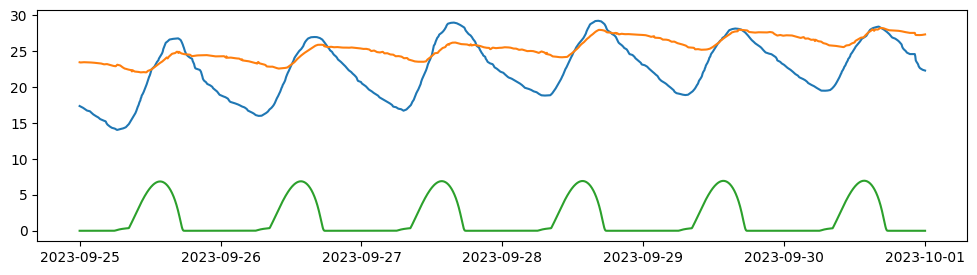

In [57]:
plt.figure(figsize=(12, 3))
plt.plot(df_A)
plt.plot(df_B)
plt.plot(irrad/100)

In [54]:
from simuthermique.pythsolver.solver_python import ThermalMassNode, ConductionLink, ExternalNode, SimpleThermalModel, DirectSource

mass = 10_000_000
h = 60
Tzero = 23
window_surface = 2

model = SimpleThermalModel(
    internal_nodes=[ThermalMassNode("room", mass, Tzero)],
    external_nodes=[ExternalNode("ext", get_interpolation_function(df_A))],
    links=[ConductionLink("ext", "room", h)],
    direct_sources=[DirectSource("room", get_interpolation_function(irrad * window_surface))]
)

In [55]:
index_sec = target_time.astype(np.int64) // 1e9
sol = model.solve_odeint(index_sec)

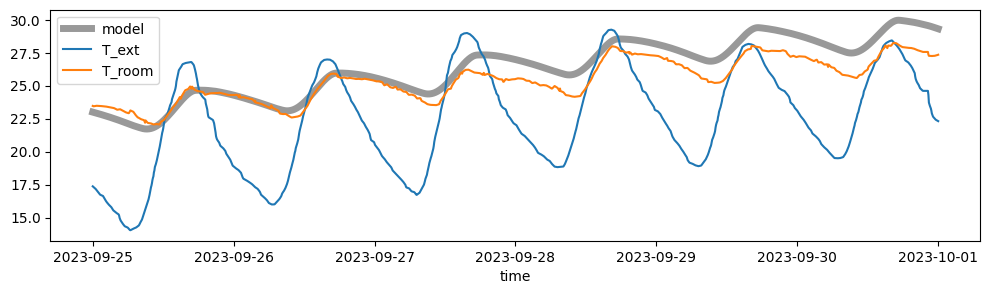

In [63]:

plt.figure(figsize=(12, 3))
# plt.plot(sources["ext"], label="ext")

plt.plot(target_time, sol[:, 0], linewidth=5, color='k', label="model", alpha=0.4)
plt.plot(target_time, df_A, label="T_ext")
plt.plot(target_time, df_B, label="T_room")

plt.legend()
plt.xlabel("time")
plt.show()


# np.testing.assert_almost_equal(T_theo, T[0, :], decimal=1) 
